In [1]:
import os, torch
#from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.fabrics_extra
import interflow.stochastic_interpolant as stochastic_interpolant
import interflow.realnvp as realnvp
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.5.1


/home/wang6559/.conda/envs/OT_IMM_home/lib/python3.10/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Device] Using: {device} | CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')}")
if device.type == "cuda":
    try:
        print("[Device] GPU:", torch.cuda.get_device_name(0))
        torch.backends.cudnn.benchmark = True
    except Exception as _e:
        print("[Device] GPU name unavailable:", _e)

def move_to(obj, device=device, non_blocking=True):
    """Recursively move tensors in nested containers to device."""
    import torch
    if torch.is_tensor(obj):
        return obj.to(device=device, non_blocking=non_blocking)
    if isinstance(obj, dict):
        return {k: move_to(v, device, non_blocking) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        seq = [move_to(x, device, non_blocking) for x in obj]
        return type(obj)(seq) if isinstance(obj, tuple) else seq
    return obj

print("[Device] Helper move_to() is defined.")


[Device] Using: cuda | CUDA_VISIBLE_DEVICES=0
[Device] GPU: NVIDIA A100 80GB PCIe
[Device] Helper move_to() is defined.


# Adversarial training of nonlinear SI to solve Schrödinger Bridge 

## Utility functions

In [14]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    #sde_flow = stochastic_interpolant.SDEIntegrator(
    #    b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    #)
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    #with torch.no_grad():
    x0_tests  = base(bs)
        #xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        #xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        #x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_pflow, logpx_pflow #, xf_sde


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    #print("EPOCH:", counter)
    #print("LOSS, GRAD:", loss, b_grad, s_grad)


    ## plot loss over time.
    #nsaves = len(data_dict['losses'])
    #epochs = np.arange(nsaves)*metrics_freq
    #axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    #axes[0].plot(epochs, data_dict['b_losses'], label="b")
    #xes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    #xes[0].set_title("LOSS")
    #axes[0].legend()


    # plot samples from SDE.
    # axes[0].scatter(
    #     xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    # axes[0].set_xlim(-5,5)
    # axes[0].set_ylim(-6.5,6.5)
    # axes[0].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[0].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[0].set_xlim(-5,5)
    axes[0].set_ylim(-6.5,6.5)
    axes[0].set_title("Samples from PFlow", fontsize=14)


    ## plot likelihood estimates.
    #axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    #axes[3].set_title(r"$\log p$ from PFlow")
    #axes[3].legend(loc='best')
    #axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
def estimate_v_squared_norm(
      v: torch.nn.Module,
      interpolant,
      base,
      target,
      n_samples: int = 1000,
      batch_size: int = 100,
      device = None
  ) -> float:
    """
    Estimate E_{t,x_0,x_1}[|v_t(I_t(x0,x1))|^2] using Monte Carlo.

    Since v expects a single t for a batch of x, we sample multiple t values
    and for each t, sample a batch of (x0, x1) pairs.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    v.eval()
    interpolant.flow_model.eval()

    v_squared_norms = []

    with torch.no_grad():
        # Determine how to split samples across time points
        n_time_samples = max(1, n_samples // batch_size)
        samples_per_t = min(batch_size, n_samples)

        ts = torch.linspace(0, 1, n_time_samples, device=device)
        for t in ts:
            t = t.unsqueeze(0)
            # Sample batch of x0, x1 for this t
            
            x0s = base(samples_per_t).to(device)
            x1s = target(samples_per_t).to(device)

            # Compute interpolated points for this t
            xts = interpolant.calc_xt(t, x0s, x1s)
            if isinstance(xts, tuple):
                xts = xts[0]

            # Evaluate velocity - v expects t with shape [1]
            vts = v(xts, t)

            # Compute squared norm |v|^2 for each sample in batch
            v_squared = torch.sum(vts ** 2, dim=-1)
            v_squared_norms.extend(v_squared.cpu().numpy())

    v.train()
    interpolant.flow_model.train()

    # Return Monte Carlo mean
    return float(np.mean(v_squared_norms))

### Training Functions

In [15]:
def total_grad_norm(params):
    norms = []
    for p in params:
        if p.grad is not None:
            norms.append(p.grad.detach().pow(2).sum())
    if not norms:
        return 0.0
    return (torch.stack(norms).sum().sqrt()).item()

def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad_(flag)
        
def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    v: torch.nn.Module,
    opt_v: torch.optim.Optimizer,
    opt_flow: torch.optim.Optimizer,  # Changed from opt_T to opt_flow for clarity
    sched_v: torch.optim.lr_scheduler._LRScheduler, 
    sched_flow: torch.optim.lr_scheduler._LRScheduler,  # Changed from sched_T to sched_flow for clarity
    n_inner: int = 1,  # Number of inner minimization steps
    n_outer: int = 1,  # Number of outer maximization steps
    reuse_batch: bool = True,
    clip_v: float = 1.0,
    clip_flow: float = 1.0,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    train_v_only: bool = False
):
    """
    Take a single step of adversarial training.
    Inner loop: minimize loss w.r.t. v
    Outer loop: maximize loss w.r.t. interpolant.flow_model
    """
    v.train()
    interpolant.flow_model.train()
    if reuse_batch:
        # construct batch
        x0s = base(bs)
        x1s = target(bs)
        ts  = torch.rand(size=(bs,))
    
    # Inner minimization: minimize over v
    set_requires_grad(interpolant.flow_model, False)
    set_requires_grad(v, True)
    
    v_grad_val = 0.0
    for _ in range(n_inner):
        if not reuse_batch:
            x0s = base(bs).to(device)
            x1s = target(bs).to(device)
            ts  = torch.rand(bs, device=device)
            
        opt_v.zero_grad(set_to_none = True)
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        loss_v.backward()
        
        if clip_v is not None and clip_v < float('inf'):
            torch.nn.utils.clip_grad_norm_(v.parameters(), clip_v)
        v_grad_val = total_grad_norm(v.parameters())
        
        opt_v.step()
        sched_v.step()
    
    if not train_v_only:
        # Outer maximization: maximize over interpolant.flow_model
        set_requires_grad(v, False)
        set_requires_grad(interpolant.flow_model, True)

        flow_grad_val = 0.0
        for _ in range(n_outer):
            if not reuse_batch:
                x0s = base(bs).to(device)
                x1s = target(bs).to(device)
                ts  = torch.rand(bs, device=device)

            opt_flow.zero_grad(set_to_none = True)
            loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)

            (-loss_flow).backward()  # Negative for maximization

            if clip_flow is not None and clip_flow < float('inf'):
                torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), clip_flow)
            flow_grad_val = total_grad_norm(interpolant.flow_model.parameters())        

            opt_flow.step()
            sched_flow.step()
        # re-enable grads for next call
        set_requires_grad(v, True)
        set_requires_grad(interpolant.flow_model, True)

        # Return the final loss values and gradients for logging
        return loss_v.detach(), loss_flow.detach(), torch.tensor(v_grad_val), torch.tensor(flow_grad_val)
    else:
        # re-enable grads for next call
        set_requires_grad(v, True)
        set_requires_grad(interpolant.flow_model, True)
        # Return the final loss values and gradients for logging
        return loss_v.detach(), torch.tensor(v_grad_val)
    
    

### Define target

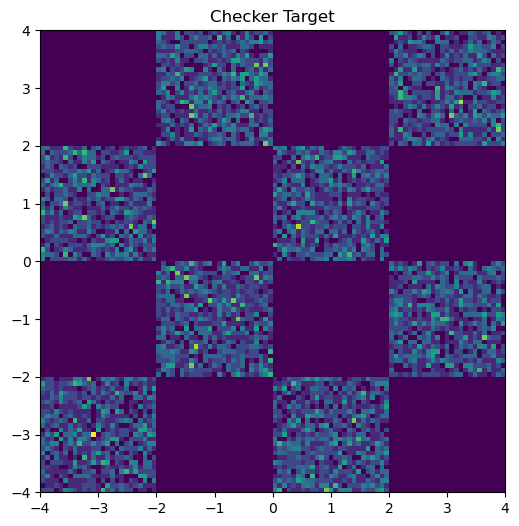

Batch Shape: (10000, 2)


In [5]:
ndim = 2
def target(bs):
    x1 = torch.rand(bs, dtype=torch.float32) * 4 - 2
    x2_ = torch.rand(bs, dtype=torch.float32) - torch.randint(2, (bs,), dtype=torch.float32) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [6]:
base_loc     = torch.zeros(ndim, device=device, dtype=torch.float32)
base_var     = torch.ones(ndim, device=device, dtype=torch.float32)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))

/tmp/ipykernel_801571/2025445577.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  base_samples = grab(torch.tensor(base(20000),dtype=torch.float32))


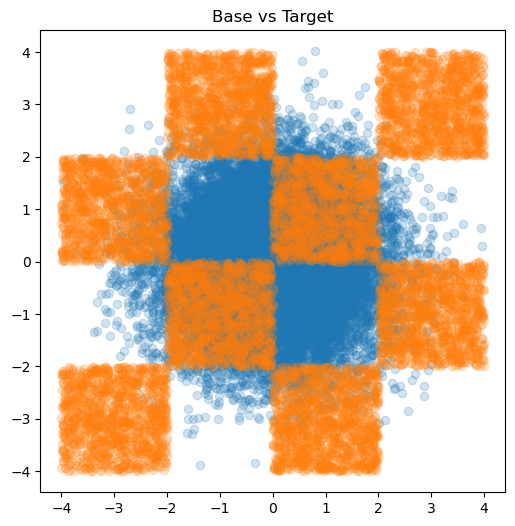

In [7]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A nonlinear interpolant.

In [16]:
path = "nonlinear"
flow_config = {
    "num_layers": 4,
    "time_embed_dim": 128,
    "hidden": 128,
    "mlp_blocks": 4,
    "activation": "gelu",
    "use_layernorm":  False,
    "use_permutation": True,
    # smoothness
    "fourier_min_freq": 1.0,
    "fourier_max_freq": 10.0,
    "vector_use_spectral_norm": True,
    "vector_log_scale_clamp":  1.0,
    "vector_use_soft_clamp":  True,
    }

data_type = "vector"
data_dim = 2

interpolant = stochastic_interpolant.Interpolant(path=path, gamma_type = None,\
    flow_config=flow_config, data_type=data_type, data_dim=data_dim)

# check trainable parameters
# These should be the same object
print(f"self.It is bound to flow_model: {interpolant.It.__self__ is interpolant.flow_model}")

# Check trainable parameters
trainable_params = sum(p.numel() for p in interpolant.flow_model.parameters())
print(f"Flow model has {trainable_params:,} trainable parameters")

self.It is bound to flow_model: True
Flow model has 265,736 trainable parameters


In [9]:
#path = 'one-sided-linear'
#interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

### Define losses for v

In [17]:
loss_fn_v = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-v')

### Define optimizers

In [18]:
base_lr_v      = 2e-4
base_lr_flow   = 2e-4  # learning rate for flow model (T_t)
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = True


# Replace your current v initialization with:

# # Option 1: Fourier Network (RECOMMENDED for checkerboard)
# v = itf.fabrics_extra.make_fourier_net(
#     hidden_sizes=[256, 256, 256],  # Moderate depth, good width
#     in_size=in_size,
#     out_size=out_size,
#     fourier_features=128,  # For 2D: 64-256 is usually enough
#     fourier_scale=15.0,    # Higher for sharper boundaries
#     inner_act='gelu',
#     use_layernorm=True
# )

# # Option 2: SIREN (Also great for sharp boundaries)
# v = make_siren(
#     hidden_sizes=[256, 256, 256, 256],
#     in_size=ndim+1,
#     out_size=ndim,
#     omega_0=30.0  # Tune this for sharpness
# )

# # Option 3: Deep ResNet (For complex time-dependent dynamics)
v = itf.fabrics_extra.make_resnet(
    hidden_sizes=[256, 256, 256, 256],  # Can be deeper due to skip connections
    in_size=in_size,
    out_size=out_size,
    inner_act='gelu',
    use_layernorm=True,
    dropout=0.0  # No dropout for 2D usually
)

#v         = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_v     = torch.optim.AdamW(v.parameters(), lr=base_lr_v, betas=(0.5,0.9), weight_decay=1e-4)
opt_flow  = torch.optim.AdamW(interpolant.flow_model.parameters(), lr=base_lr_flow, betas=(0.5,0.9), weight_decay=1e-4)
sched_v   = torch.optim.lr_scheduler.StepLR(optimizer=opt_v, step_size=1500, gamma=0.4)
sched_flow = torch.optim.lr_scheduler.StepLR(optimizer=opt_flow, step_size=1500, gamma=0.4)


eps          = torch.tensor(0)
N_epoch      = 15
bs           = 500    # Increased batch size for better GPU utilization
n_inner      = 100     # inner minimization steps for v
n_outer      = 50     # outer maximization steps for flow model

plot_bs      = 5000  # number of samples to use when plotting
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]

if print_model:
    print("Here's the model v:", v)

Here's the model v: InputWrapper(
  (v): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Identity()
    )
    (3): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Identity()
    )
    (4): ResBlock(
      (fc1): Linear(in_features=256, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layernorm): LayerNorm((256,), eps=1e-05, ele

In [19]:
data_dict = {
    'v_losses': [],
    'flow_losses': [],  # Changed from T_losses
    'v_grads': [],
    'flow_grads': [],   # Changed from T_grads
    'times': [],
    'logps_pflow': [],
    'v_squared_norm': [],  # Add E[|v|^2] tracking
}

counter = 1

# Training Loop with Adversarial Training

Epoch 1: v_loss=-1.9549, flow_loss=-1.9744, v_grad=3.8644, flow_grad=1.8337,E[|v|²]=3.6654


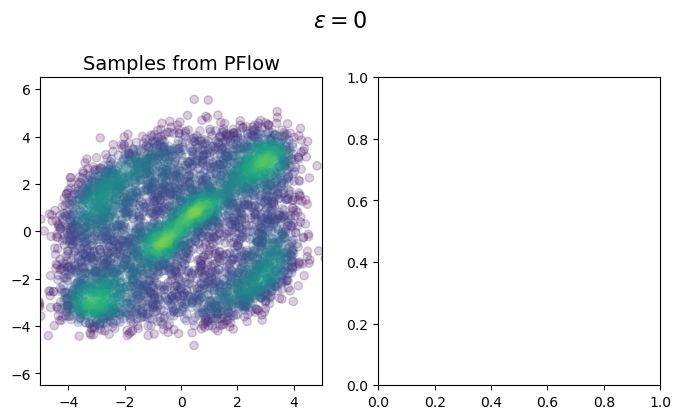

Epoch 2: v_loss=-2.2413, flow_loss=-0.5313, v_grad=3.6154, flow_grad=5.4746,E[|v|²]=3.6091


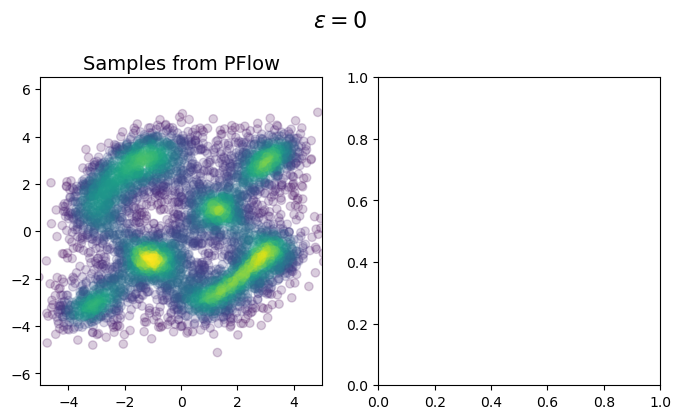

KeyboardInterrupt: 

In [13]:
# Phase 1: Solve SBP
for epoch in range(N_epoch):  # Run for a few epochs to test
    # Take a training step with adversarial training
    # if epoch < 100:
    #     n_inner = 100
    #     n_outer = 1
    # # Later: Focus on improving interpolant
    # else:
    #     n_inner = 20
    #     n_outer = 20
    loss_v, loss_flow, v_grad, flow_grad = train_step(
        bs=bs,
        interpolant=interpolant,
        v=v,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=n_inner,
        n_outer=n_outer,
        reuse_batch=False,
        clip_v=float('inf'),
        clip_flow=float('inf'),
        #device=device,
    )

    
    # Log metrics
    data_dict['v_losses'].append(grab(loss_v).mean())
    data_dict['flow_losses'].append(grab(loss_flow).mean())
    data_dict['v_grads'].append(grab(v_grad).mean())
    data_dict['flow_grads'].append(grab(flow_grad).mean())
    
    # Estimate and log E[|v|^2]
    v_sq_norm = estimate_v_squared_norm(v, interpolant, base, target,
                                          n_samples=10000, batch_size = 500, device=device)
    data_dict['v_squared_norm'].append(v_sq_norm)
    
    # Print with gradient info for verification
    print(f"Epoch {epoch+1}: v_loss={loss_v.detach().item():.4f}, "
        f"flow_loss={loss_flow.detach().item():.4f}, "
        f"v_grad={v_grad.detach().item():.4f}, "
        f"flow_grad={flow_grad.detach().item():.4f},"
        f"E[|v|²]={v_sq_norm:.4f}")    
    counter += 1
    make_plots(v, v, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, torch.tensor(0), data_dict)

In [15]:
# Phase 2: optimize v to achieve transport
data_dict_v = {
    'losses': [],
    'v_grads': [],
    'times': [],
    'logps_pflow': [],
    'v_squared_norm': [],  # Add E[|v|^2] tracking
}

Epoch 1: v_loss=-2.8986, v_grad=6.6928, 


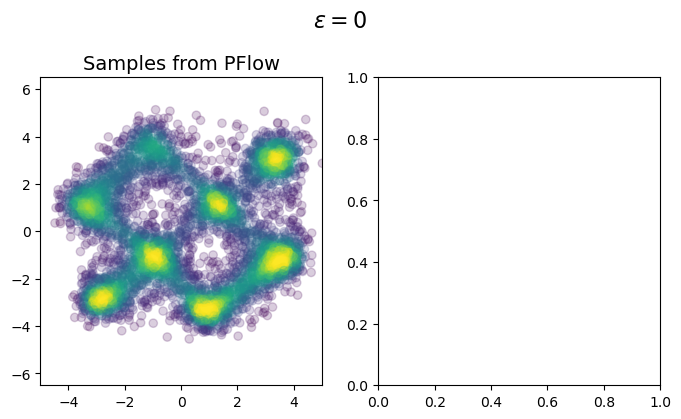

Epoch 2: v_loss=-1.9184, v_grad=3.7943, 


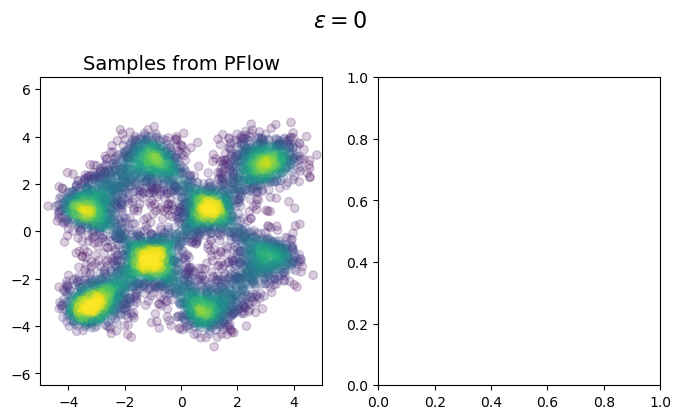

KeyboardInterrupt: 

In [16]:
# Phase 2: Train v
for epoch in range(15):  # Run for a few epochs to test
    loss_v, v_grad = train_step(
        bs=bs,
        interpolant=interpolant,
        v=v,
        opt_v=opt_v,
        opt_flow=opt_flow,
        sched_v=sched_v,
        sched_flow=sched_flow,
        n_inner=500,
        n_outer=n_outer,
        reuse_batch=False,
        clip_v=float('inf'),
        clip_flow=float('inf'),
        #device=device,
        train_v_only = True
    )

    
    # Log metrics
    data_dict_v['losses'].append(grab(loss_v).mean())
    data_dict_v['v_grads'].append(grab(v_grad).mean())
    
    # Estimate and log E[|v|^2]
    v_sq_norm = estimate_v_squared_norm(v, interpolant, base, target,
                                          n_samples=10000, batch_size = 500, device=device)
    data_dict_v['v_squared_norm'].append(v_sq_norm)
    
    # Print with gradient info for verification
    print(f"Epoch {epoch+1}: v_loss={loss_v.detach().item():.4f}, "
        f"v_grad={v_grad.detach().item():.4f}, ")
        #f"E[|v|²]={v_sq_norm:.4f}")    
    counter += 1
    make_plots(v, v, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, torch.tensor(0), data_dict)

In [ ]:
# Plot E[|v|^2] over training
if len(data_dict['v_squared_norm']) > 0:
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(data_dict['v_squared_norm'], 'b-', label='E[|v|²]')
    plt.xlabel('Epoch')
    plt.ylabel('E[|v|²]')
    plt.title('Velocity Squared Norm During Training')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(data_dict['v_losses'], 'g-', label='v loss', alpha=0.7)
    plt.plot(data_dict['flow_losses'], 'r-', label='flow loss', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

### Post Training

In [42]:
os.makedirs("checkpoints", exist_ok=True)

torch.save({
    "v": v.state_dict(),
    "flow": interpolant.flow_model.state_dict(),
}, "checkpoints/weights_only.pt")

#ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
#v.load_state_dict(ckpt["v"])
#interpolant.flow_model.load_state_dict(ckpt["flow"])

In [34]:
ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)
v.load_state_dict(ckpt["v"])
interpolant.flow_model.load_state_dict(ckpt["flow"])

/tmp/ipykernel_3554308/1742592006.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/weights_only.pt", map_location=device)


<All keys matched successfully>

# Warm-up training and regularization

Experiments that investigate whether warm-up & regularization can help to train v. 

In [30]:
class WarmupInterpolant(torch.nn.Module):
    """
    Wrapper that forwards all attributes to base_interpolant except calc_xt and dtIt.
    """
    def __init__(self, base_interpolant, warmup_steps=1000):
        super().__init__()
        self.base_interpolant = base_interpolant
        self.warmup_steps = warmup_steps
        self.current_step = 0

    def __getattr__(self, name):
        """Forward all unknown attributes to base_interpolant."""
        # Avoid infinite recursion for module attributes
        if name in ['base_interpolant', 'warmup_steps', 'current_step']:
            return super().__getattr__(name)

        # For calc_xt and dtIt, use our warmed-up versions
        if name in ['calc_xt', 'dtIt']:
            return super().__getattr__(name)

        # Forward everything else to base_interpolant (including flow_model)
        return getattr(self.base_interpolant, name)

    def set_step(self, step):
        self.current_step = step

    def get_warmup_factor(self):
        if self.current_step >= self.warmup_steps:
            return 1.0
        #return 0.5 * (1 - np.cos(np.pi * self.current_step / self.warmup_steps))
        return 0

    def calc_xt(self, t, x0, x1):
        # Same implementation as before
        xt_complex = self.base_interpolant.calc_xt(t, x0, x1)
        
        if isinstance(xt_complex, tuple):
            xt_complex = xt_complex[0]
        
        # Simple interpolation
        t_tensor = torch.as_tensor(t, dtype=x0.dtype, device=x0.device)
        if t_tensor.dim() == 0:
            t_tensor = t_tensor.unsqueeze(0)

        a = torch.cos(0.5 * np.pi * t_tensor)
        b = torch.sin(0.5 * np.pi * t_tensor)

        while a.dim() < x0.dim():
            a = a.unsqueeze(-1)
            b = b.unsqueeze(-1)

        xt_simple = a * x0 + b * x1

        alpha = self.get_warmup_factor()
        return alpha * xt_complex + (1 - alpha) * xt_simple

    def dtIt(self, t, x0, x1):
        # Same implementation as before
        dtIt_complex = self.base_interpolant.dtIt(t, x0, x1)

        t_tensor = torch.as_tensor(t, dtype=x0.dtype, device=x0.device)
        if t_tensor.dim() == 0:
            t_tensor = t_tensor.unsqueeze(0)

        adot = -0.5 * np.pi * torch.sin(0.5 * np.pi * t_tensor)
        bdot = 0.5 * np.pi * torch.cos(0.5 * np.pi * t_tensor)

        while adot.dim() < x0.dim():
            adot = adot.unsqueeze(-1)
            bdot = bdot.unsqueeze(-1)

        dtIt_simple = adot * x0 + bdot * x1

        alpha = self.get_warmup_factor()
        return alpha * dtIt_complex + (1 - alpha) * dtIt_simple
    
def compute_time_smoothness_loss(
      interpolant, 
      base, 
      target, 
      n_samples=100,
      n_time_points=10,
      eps=0.01,
      device=None
  ):
    """
    Compute smoothness regularization for the interpolant.
    Penalizes large second derivatives in time.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    total_smoothness = 0.0

    # Sample across time grid
    ts = torch.linspace(0.1, 0.9, n_time_points, device=device)  # Avoid boundaries

    for t in ts:
        # Sample data
        x0s = base(n_samples).to(device)
        x1s = target(n_samples).to(device)

        # Compute at three time points for second derivative
        t_minus = torch.clamp(t - eps, 0, 1).unsqueeze(0)
        t_center = t.unsqueeze(0)
        t_plus = torch.clamp(t + eps, 0, 1).unsqueeze(0)

        # Get interpolations
        xt_minus = interpolant.calc_xt(t_minus, x0s, x1s)
        xt_center = interpolant.calc_xt(t_center, x0s, x1s)
        xt_plus = interpolant.calc_xt(t_plus, x0s, x1s)

        if isinstance(xt_minus, tuple):
            xt_minus, xt_center, xt_plus = xt_minus[0], xt_center[0], xt_plus[0]

        # Approximate second derivative
        d2_xt_dt2 = (xt_plus - 2*xt_center + xt_minus) / (eps**2)

        # Penalize large second derivatives
        smoothness = torch.mean(d2_xt_dt2.pow(2))
        total_smoothness += smoothness

    return total_smoothness / n_time_points

def compute_jacobian_regularization(
      interpolant,
      x0s,
      x1s,
      t,
      eps=0.01
  ):
    """
    Regularize the Jacobian of the flow to be smooth.
    """
    x0s = x0s.requires_grad_(True)
    x1s = x1s.requires_grad_(True)

    # Get interpolation
    xt = interpolant.calc_xt(t, x0s, x1s)
    if isinstance(xt, tuple):
        xt = xt[0]

    # Compute Jacobian norm
    jacobian = torch.autograd.grad(
      xt.sum(),
      [x0s, x1s],
      create_graph=True,
      retain_graph=True
    )

    jac_norm = sum(j.pow(2).mean() for j in jacobian)
    return jac_norm

def train_step_with_regularization(
      bs: int,
      interpolant,
      v: torch.nn.Module,
      opt_v: torch.optim.Optimizer,
      opt_flow: torch.optim.Optimizer,
      sched_v, 
      sched_flow,
      n_inner: int = 100,
      n_outer: int = 1,
      lambda_smooth: float = 0.1,  # Smoothness weight
      lambda_jac: float = 0.01,     # Jacobian weight
      warmup_step: int = 0,
      device=None,
  ):
    """
    Adversarial training with smoothness regularization.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Update warmup if using WarmupInterpolant
    if hasattr(interpolant, 'set_step'):
        interpolant.set_step(warmup_step)

    # Sample batch
    x0s = base(bs).to(device)
    x1s = target(bs).to(device)
    ts = torch.rand(bs, device=device)

    # Inner minimization: train v
    set_requires_grad(interpolant.flow_model, False)
    set_requires_grad(v, True)

    for _ in range(n_inner):
        opt_v.zero_grad()
        loss_v = loss_fn_v(v, x0s, x1s, ts, interpolant)
        loss_v.backward()
        torch.nn.utils.clip_grad_norm_(v.parameters(), 1.0)
        opt_v.step()

    # Outer maximization: train interpolant with regularization
    set_requires_grad(v, False)
    set_requires_grad(interpolant.flow_model, True)

    for _ in range(n_outer):
        opt_flow.zero_grad()

        # Main adversarial loss
        loss_flow = loss_fn_v(v, x0s, x1s, ts, interpolant)

#         # Smoothness regularization
#         smooth_loss = compute_time_smoothness_loss(
#           interpolant, base, target,
#           n_samples=50, device=device
#         )

#         # Jacobian regularization
#         jac_loss = compute_jacobian_regularization(
#           interpolant, x0s, x1s, ts[0]
#         )

        # Combined loss (maximize main, minimize regularization)
        total_loss = -loss_flow #+ lambda_smooth * smooth_loss + lambda_jac * jac_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(interpolant.flow_model.parameters(), 0.5)  # Small!
        opt_flow.step()

    sched_v.step()
    sched_flow.step()

    set_requires_grad(v, True)
    set_requires_grad(interpolant.flow_model, True)

    return loss_v.detach(), loss_flow.detach()#, smooth_loss.detach(), jac_loss.detach()

## smooth initialization
def initialize_smooth_interpolant(flow_config):
    """
    Initialize interpolant to be very smooth initially.
    """
    smooth_config = flow_config.copy()
    smooth_config.update({
      "num_layers": 2,  # Start with very few layers
      "hidden": 64,      # Small network
      "mlp_blocks": 2,
      "vector_log_scale_clamp": 0.5,  # Very small initially
      "vector_use_soft_clamp": True,
      "vector_use_spectral_norm": True,
      "fourier_max_freq": 10.0,  # Very low frequencies initially
    })

    # Create interpolant
    interpolant = stochastic_interpolant.Interpolant(
      path="nonlinear",
      gamma_type=None,
      flow_config=smooth_config,
      data_type="vector",
      data_dim=2
    )

    # Initialize flow near identity
    with torch.no_grad():
        for param in interpolant.flow_model.parameters():
            param.data *= 0.1  # Scale down all parameters

    return interpolant

In [31]:
# Training with progressive schedule
N_warmup = 100
N_main = 10
N_finetune = 10

# Phase 1: Warmup with strong regularization
print("Phase 1: Warmup")
#interpolant = initialize_smooth_interpolant(flow_config)
warmup_interpolant = WarmupInterpolant(interpolant, warmup_steps=N_warmup)

for epoch in range(N_warmup):
    loss_v, loss_flow = train_step_with_regularization(#, smooth_loss, jac_loss
      bs=bs,
      interpolant=warmup_interpolant,
      v=v,
      opt_v=opt_v,
      opt_flow=opt_flow,
      sched_v=sched_v,
      sched_flow=sched_flow,
      n_inner=100,
      n_outer=1,
      lambda_smooth=0.5,  # Strong smoothness
      lambda_jac=0.1,
      warmup_step=epoch,
      device=device
    )

    if epoch % 1 == 0:
        print(f"Warmup {epoch}: velocity loss={loss_v:.4f}")
        make_plots(v, v, warmup_interpolant, n_save, n_step, plot_bs, counter, metrics_freq, torch.tensor(0), data_dict)

Phase 1: Warmup
torch.Size([1, 2])
torch.Size([1, 2])


NotImplementedError: Cannot access storage of BatchedTensorImpl

In [ ]:
# Phase 2: Main training with moderate regularization
print("\nPhase 2: Main Training")
for epoch in range(N_main):
    loss_v, loss_flow, smooth_loss, jac_loss = train_step_with_regularization(
      bs=bs,
      interpolant=interpolant,  # Use base interpolant now
      v=v,
      opt_v=opt_v,
      opt_flow=opt_flow,
      sched_v=sched_v,
      sched_flow=sched_flow,
      n_inner=100,
      n_outer=20,
      lambda_smooth=0.1,  # Reduced smoothness
      lambda_jac=0.01,
      device=device
    )

    if epoch % 1 == 0:
        v_sq = estimate_v_squared_norm(v, interpolant, base, target, device=device)
        print(f"Main {epoch}: v_loss={loss_v:.4f}, E[|v|²]={v_sq:.4f}, smooth={smooth_loss:.4f}")
        make_plots(v, v, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, torch.tensor(0), data_dict)

In [ ]:
# Phase 3: Fine-tuning with minimal regularization
print("\nPhase 3: Fine-tuning")
for epoch in range(N_finetune):
    # Train with very little regularization to get sharp boundaries
    loss_v, loss_flow, smooth_loss, jac_loss = train_step_with_regularization(
      bs=bs,
      interpolant=interpolant,
      v=v,
      opt_v=opt_v,
      opt_flow=opt_flow,
      sched_v=sched_v,
      sched_flow=sched_flow,
      n_inner=200,  # More v training
      n_outer=1,
      lambda_smooth=0.01,  # Minimal smoothness
      lambda_jac=0.001,
      device=device
    )
    make_plots(v, v, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, torch.tensor(0), data_dict)